In [ ]:
import os

# Base directory for the dataset
dataset_dir = "/kaggle/input/cats-vs-dogs"

# List files in the dataset directory
print(os.listdir(dataset_dir))


In [ ]:
#the model parameters
#batch size = 32
#

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets, models
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
import os

# Path to the folder with images
image_folder_path = '/kaggle/input/cats-vs-dogs/train/train'

# List all files in the folder
image_files = os.listdir(image_folder_path)

# Filter out non-image files (if any)
image_files = [f for f in image_files if f.lower().endswith(('png', 'jpg', 'jpeg', 'bmp', 'gif'))]

# Display the first few image file names
image_files[:5]


['cat.12461.jpg',
 'dog.3443.jpg',
 'dog.7971.jpg',
 'dog.10728.jpg',
 'dog.1942.jpg']

In [4]:
# Create a simple mapping of labels based on filenames
def extract_label(filename):
    # Example: If filenames contain 'cat' or 'dog', map to a class
    if 'cat' in filename.lower():
        return 0  # Label for cat
    elif 'dog' in filename.lower():
        return 1  # Label for dog
    else:
        return -1  # Unlabeled image (can handle this case)

# Create a list of labels for all images
labels = [extract_label(f) for f in image_files]

# Show the first few labels
labels[:5]


[0, 1, 1, 1, 1]

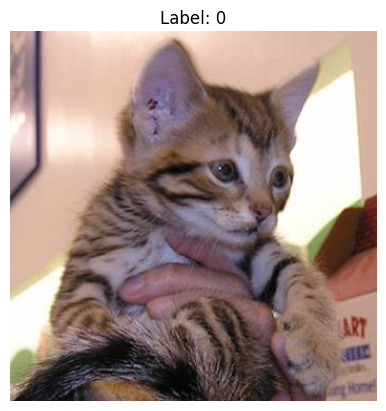

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

# Load an image (replace with the path to one of your images)
image_path = os.path.join(image_folder_path, image_files[0])
image = Image.open(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes for a cleaner view
plt.title(f"Label: {labels[0]}")
plt.show()


In [6]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.utils.data import random_split

# Define a custom dataset
class ImageDataset(Dataset):
    def __init__(self, image_folder_path, image_files, labels, transform=None):
        self.image_folder_path = image_folder_path
        self.image_files = image_files
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Get image path
        image_path = os.path.join(self.image_folder_path, self.image_files[idx])
        image = Image.open(image_path)
        
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        label = self.labels[idx]
        return image, label

# Define transformations (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor()  # Convert to tensor
])

# Create the dataset
full_dataset = ImageDataset(image_folder_path, image_files, labels, transform=transform)
# Define the split ratio (e.g., 80% for training and 20% for validation)
train_size = int(0.8 * len(full_dataset))  # 80% for training
val_size = len(full_dataset) - train_size  # Remaining 20% for validation

# Randomly split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Now you can create DataLoader for both datasets
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=0, pin_memory=False,drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=0,pin_memory=False,drop_last=True)

# Display a sample image and its label



In [7]:
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 20000
Validation dataset size: 5000


In [17]:
import torch.nn as nn
import torch.nn.init as init

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.tanh1 = nn.Tanh()  # Replace ReLU with Tanh
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop1 = nn.Dropout(0.25)

        # Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.tanh2 = nn.Tanh()  # Replace ReLU with Tanh
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop2 = nn.Dropout(0.25)

        # Third convolutional block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.tanh3 = nn.Tanh()  # Replace ReLU with Tanh
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop3 = nn.Dropout(0.25)

        # Flatten size calculation
        self.flatten_size = self.calculate_flatten_size()

        # Fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 512)
        self.fc2 = nn.Linear(512, 2)  # Output layer for 2 classes

        # Dropout for fully connected layers
        self.drop_fc = nn.Dropout(0.5)

        # Xavier Initialization
        self._initialize_weights()

    def calculate_flatten_size(self):
        dummy_input = torch.zeros(1, 3, 128, 128)
        x = self.pool1(self.tanh1(self.bn1(self.conv1(dummy_input))))
        x = self.pool2(self.tanh2(self.bn2(self.conv2(x))))
        x = self.pool3(self.tanh3(self.bn3(self.conv3(x))))
        return x.numel()

    def forward(self, x):
        x = self.pool1(self.tanh1(self.bn1(self.conv1(x))))
        x = self.pool2(self.tanh2(self.bn2(self.conv2(x))))
        x = self.pool3(self.tanh3(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop_fc(x)
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        # Apply Xavier initialization to Conv and Linear layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.xavier_normal_(m.weight)  # Xavier normal initialization
                if m.bias is not None:
                    init.constant_(m.bias, 0)  # Bias initialized to 0
            elif isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)  # Xavier normal initialization
                if m.bias is not None:
                    init.constant_(m.bias, 0)  # Bias initialized to 0


In [9]:
from tqdm import tqdm

Epoch [1/10], Loss: 63.3850
Epoch [2/10], Loss: 0.8318
Epoch [3/10], Loss: 1.0691
Epoch [4/10], Loss: 1.3493
Epoch [5/10], Loss: 1.0050
Epoch [6/10], Loss: 1.5323
Epoch [7/10], Loss: 1.2002
Epoch [8/10], Loss: 1.5258
Epoch [9/10], Loss: 1.6151
Epoch [10/10], Loss: 1.0168


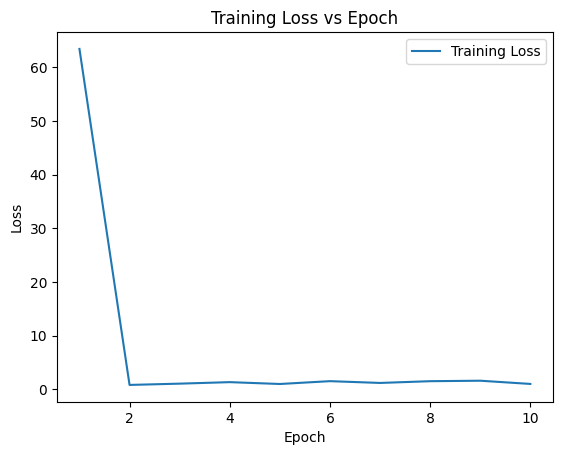

In [21]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

# Assuming you've already defined your model class (CustomCNN) and dataset

# Initialize the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model = CustomCNN().to(device)

# Loss function (Criterion)
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss is suitable for multi-class classification

# Optimizer with weight decay (L2 regularization)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001, momentum=0.9)


# Xavier initialization (already part of the CustomCNN model)
# This is automatically called in the model initialization.

# Training loop
num_epochs = 10  # Number of epochs
train_losses = []  # To store the loss for each epoch

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in train_loader:  # Assuming train_loader is your DataLoader for training data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

# After training, plot the training loss
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.show()


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU (or CPU if no GPU)


CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout(p=0

In [22]:
def evaluate_model(model, test_loader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to track gradients during evaluation
        for images, labels in test_loader:
            # Move images and labels to the same device as the model
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # Forward pass through the model
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total += labels.size(0)  # Total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = 100 * correct / total
    return accuracy


In [23]:
accuracy = evaluate_model(model, val_loader, device)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 66.53%
